### Import des modules

In [4]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
from keras import backend as K
from keras_tuner import RandomSearch
import warnings
from glob import glob
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

### Chargement du modèle de segmentation

In [5]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return K.mean(K.equal(y_true, K.round(y_pred)))

def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = keras.layers.Dropout(rate)
        self.c2 = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = keras.layers.MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

class DecoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = keras.layers.UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = keras.layers.concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }


class AttentionGate(keras.layers.Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = keras.layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = keras.layers.Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = keras.layers.UpSampling2D()
        self.BN = keras.layers.BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = keras.layers.Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = keras.layers.Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

class ShowProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = X_train[id]
        mask = seg_train[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [7]:
# Inputs
input_layer = keras.layers.Input(shape=(224,224,3))

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
unet_model = keras.models.Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
unet_model.compile(
    loss=[jaccard_distance],
    optimizer='adam',
    metrics=[accuracy, precision, recall, iou]
)

unet_model.load_weights("AttentionCustomUNet.h5")

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [8]:
def enhance(img):
    sub = img.flatten()
    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub.reshape(224,224,1)

### Prétraitement des données

In [13]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv("PH2Dataset/HAM10000_metadata.csv")
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [14]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,Actinic keratoses,0


In [15]:
df_no_dup = skin_df.groupby('lesion_id').count()
df_no_dup = df_no_dup[df_no_dup['image_id']==1]
df_no_dup.reset_index(inplace=True)
df_no_dup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1


In [16]:
def get_duplicates(x):
    unique_list = list(df_no_dup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

skin_df['duplicates'] = skin_df['lesion_id']
skin_df['duplicates'] = skin_df['duplicates'].apply(get_duplicates)
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,duplicated


In [17]:
skin_df['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [18]:
df_no_dup = skin_df[skin_df['duplicates'] == 'unduplicated']
df_no_dup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,Benign keratosis-like lesions,2,unduplicated
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,2,unduplicated
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,Benign keratosis-like lesions,2,unduplicated
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,unduplicated
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,Benign keratosis-like lesions,2,unduplicated


In [19]:
y = df_no_dup['cell_type_idx']
_, df_val = train_test_split(df_no_dup, test_size=0.2, random_state=101, stratify=y)
df_val.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
4781,HAM_0000199,ISIC_0026127,nv,follow_up,55.0,male,lower extremity,Melanocytic nevi,4,unduplicated
3294,HAM_0006655,ISIC_0025994,nv,follow_up,50.0,female,lower extremity,Melanocytic nevi,4,unduplicated
1421,HAM_0002897,ISIC_0030552,mel,histo,75.0,male,back,Melanoma,5,unduplicated
9816,HAM_0004563,ISIC_0031211,akiec,histo,75.0,male,lower extremity,Actinic keratoses,0,unduplicated
8611,HAM_0004275,ISIC_0026921,nv,histo,70.0,female,back,Melanocytic nevi,4,unduplicated


In [20]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [21]:
def get_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

skin_df['train_or_val'] = skin_df['image_id']
skin_df['train_or_val'] = skin_df['train_or_val'].apply(get_val_rows)
df_train = skin_df[skin_df['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [22]:
df_train['cell_type_idx'].value_counts()

4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [23]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [24]:
data_aug_rate = [15,10,5,50,0,5,40]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

/var/folders/j6/y8kx6d653d77lgg35197v5x00000gn/T/ipykernel_2236/3182111157.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


Melanocytic nevi                  5822
Dermatofibroma                    5350
Melanoma                          5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [25]:
df_train, df_test = train_test_split(df_train, test_size=.1)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_val.reset_index(inplace=True)

### Chargement des données

In [26]:
def create_dataset(df):
    images = []
    labels = []
    for image_id in df['image_id'].values:
        img = cv2.cvtColor(cv2.imread(os.path.join("PH2Dataset/HAM10000_images", image_id+'.jpg')),cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224),interpolation=cv2.INTER_AREA)
        img = np.array(img, dtype='float32')
        img /= 255
        images.append(img)
        labels.append(df.loc[df['image_id']==image_id]['cell_type_idx'].values[0])
    return np.array(images), np.array(labels)

In [27]:
X_train, y_train = create_dataset(df_train)
y_train = to_categorical(y_train)

In [28]:
X_test, y_test = create_dataset(df_test)
y_test = to_categorical(y_test)

In [29]:
X_val, y_val = create_dataset(df_val)
y_val = to_categorical(y_val)

In [30]:
masks_train = []
prev = 0

for i in range(3237,32371,3237):
    masks = unet_model.predict(X_train[prev:i],verbose=0)
    masks_train.append(masks)
    prev = i

enhanced_masks = []
for masks in masks_train:
    for mask in masks:
        enhanced_masks.append(enhance(mask))

masks_train = np.array(enhanced_masks)

2024-01-09 09:51:10.711131: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [31]:
masks = unet_model.predict(X_val,verbose=0)
enhanced_masks = []
for mask in masks:
    enhanced_masks.append(enhance(mask))
masks_val = np.array(enhanced_masks)

In [32]:
masks = unet_model.predict(X_test,verbose=0)
enhanced_masks = []
for mask in masks:
    enhanced_masks.append(enhance(mask))
masks_test = np.array(enhanced_masks)

In [33]:
X_train = np.concatenate((masks_train, masks_train, masks_train),axis=3)
masks_train = []
X_test = np.concatenate((masks_test, masks_test, masks_test),axis=3)
masks_test = []
X_val = np.concatenate((masks_val, masks_val, masks_val),axis=3)
masks_val = []
masks = []
enhanced_masks = []

In [34]:
print("Dimensions du Training Set   : {}".format(X_train.shape))
print("Dimensions du Test Set       : {}".format(X_test.shape))
print("Dimensions du Validation Set       : {}".format(X_val.shape))

Dimensions du Training Set   : (32370, 224, 224, 3)
Dimensions du Test Set       : (3597, 224, 224, 3)
Dimensions du Validation Set       : (1103, 224, 224, 3)


### Modèle de classification

In [35]:
def build_model(hp):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Input(shape=[224, 224, 3]))
    model.add(keras.layers.Conv2D(hp.Int("units_1",16,32,step=16,default=32), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(hp.Int("units_2",32,64,step=32,default=64), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_2",32,64,step=32,default=64), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(hp.Int("units_3",64,128,step=64,default=128), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_3",64,128,step=64,default=128), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(hp.Int("units_4",128,256,step=128,default=256), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.Conv2D(hp.Int("units_4",128,256,step=128,default=256), (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(rate=hp.Float("rate",0.2,0.5,step=.1,default=0.2)))
    model.add(keras.layers.Dense(hp.Int("units_5",128,256,step=128,default=256), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_6",64,128,step=64,default=128), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_7",32,64,step=32,default=64), activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(hp.Int("units_8",16,32,step=16,default=32), activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
    return model

tuner = RandomSearch(
        build_model,
        objective = "val_accuracy",
        max_trials = 5,
        executions_per_trial = 1
)

stop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=2,factor=0.5,min_lr=0.00001)

In [36]:
with tf.device("CPU"):
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4*128).batch(128)
    validate = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128)

### Entrainement

In [37]:
tuner.search(
    train,
    validation_data= validate,
    epochs=5,
    callbacks=[stop_callback, lr_callback]
)

Trial 5 Complete [00h 08m 44s]
val_accuracy: 0.7443336248397827

Best val_accuracy So Far: 0.8005439639091492
Total elapsed time: 00h 44m 41s
INFO:tensorflow:Oracle triggered exit


In [38]:
models = tuner.get_best_models(num_models=1)
model = models[0]
history = model.fit(
    train,
    validation_data = validate,
    epochs=6,
    callbacks=[stop_callback, lr_callback]
)

Epoch 1/6


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C128H1W50176 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x50176xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.app

252/253 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.8150

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C114H1W50176 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x114x1x50176xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.app

253/253 [==============================] - 143s 561ms/step - loss: 0.5775 - accuracy: 0.8153 - val_loss: 0.9887 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 2/6
253/253 [==============================] - 142s 561ms/step - loss: 0.2767 - accuracy: 0.9121 - val_loss: 0.9474 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 3/6
253/253 [==============================] - 143s 565ms/step - loss: 0.1601 - accuracy: 0.9494 - val_loss: 1.0037 - val_accuracy: 0.7888 - lr: 0.0010
Epoch 4/6
253/253 [==============================] - 141s 558ms/step - loss: 0.0735 - accuracy: 0.9789 - val_loss: 1.1915 - val_accuracy: 0.7706 - lr: 0.0010
Epoch 5/6
253/253 [==============================] - 141s 559ms/step - loss: 0.0499 - accuracy: 0.9863 - val_loss: 1.3251 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 6/6
253/253 [==============================] - 141s 559ms/step - loss: 0.0219 - accuracy: 0.9949 - val_loss: 1.2671 - val_accuracy: 0.7743 - lr: 5.0000e-04


In [39]:
# model.evaluate(X_test, y_test)

113/113 [==============================] - 6s 51ms/step - loss: 0.0434 - accuracy: 0.9867


[0.04339959844946861, 0.9866555333137512]

### Visualisation et preds

In [9]:
def print_confusion_matrix(confusion_matrix,class_names,figsize=(10,7),fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix,index=class_names,columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm,annot=True,fmt='d')
    except ValueError:
        raise ValueError("Confusion matrix must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha="right",fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha="right",fontsize=fontsize)
    plt.ylabel("Truth")
    plt.xlabel("Prediction")

In [41]:
predictions = model.predict(X_test)
prediction_labels = np.argmax(predictions,1)

113/113 [==============================] - 5s 45ms/step


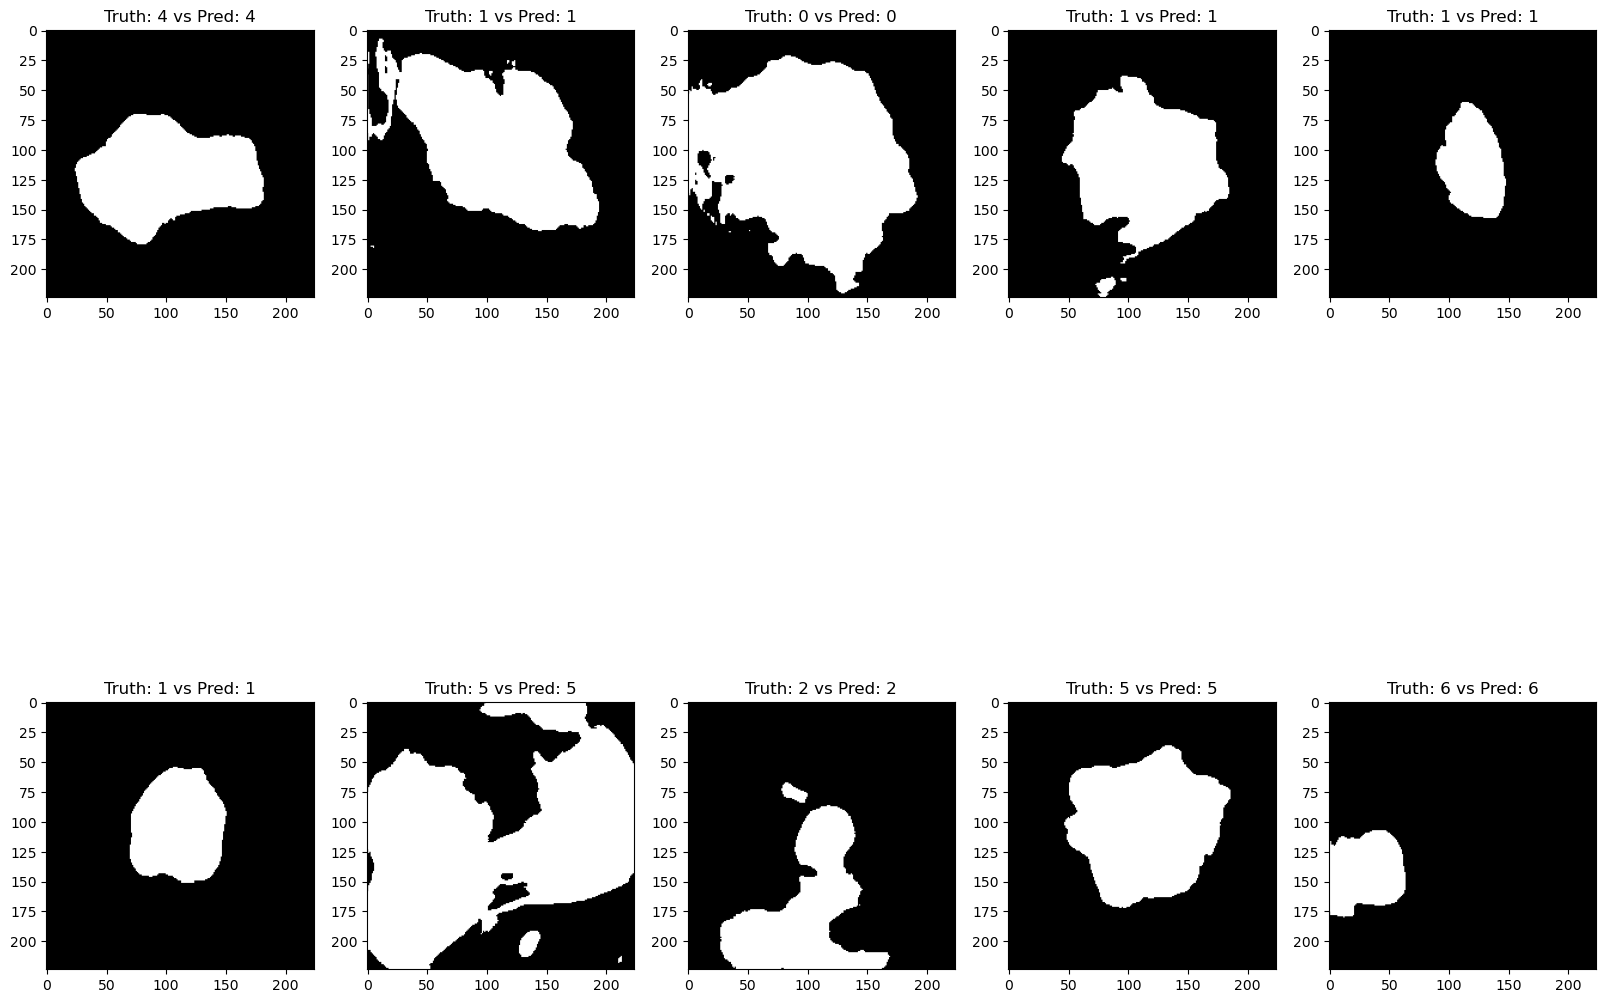

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(20,16))

for j in range(5):
    axes[0,j].imshow(X_test[j])
    axes[1,j].imshow(X_test[j+5], cmap="gray")
    axes[0,j].set_title(f"Truth: {np.argmax(y_test[j])} vs Pred: {prediction_labels[j]}")
    axes[1,j].set_title(f"Truth: {np.argmax(y_test[j+5])} vs Pred: {prediction_labels[j+5]}")

plt.show()

### Pipeline

In [46]:
images, labels = create_dataset(df_test)

In [10]:
model = keras.models.load_model("test_skin.h5")

In [11]:
def predict(image):
    mask = unet_model.predict(image.reshape(1,224,224,3),verbose=0)
    mask = enhance(mask)
    mask = np.concatenate((mask, mask, mask),axis=2)
    pred = model.predict(mask.reshape(1,224,224,3),verbose=0)
    pred = np.argmax(pred, 1)[0]
    return pred

In [51]:
preds = []

for image in images:
    preds.append(predict(image))

preds = np.array(preds)

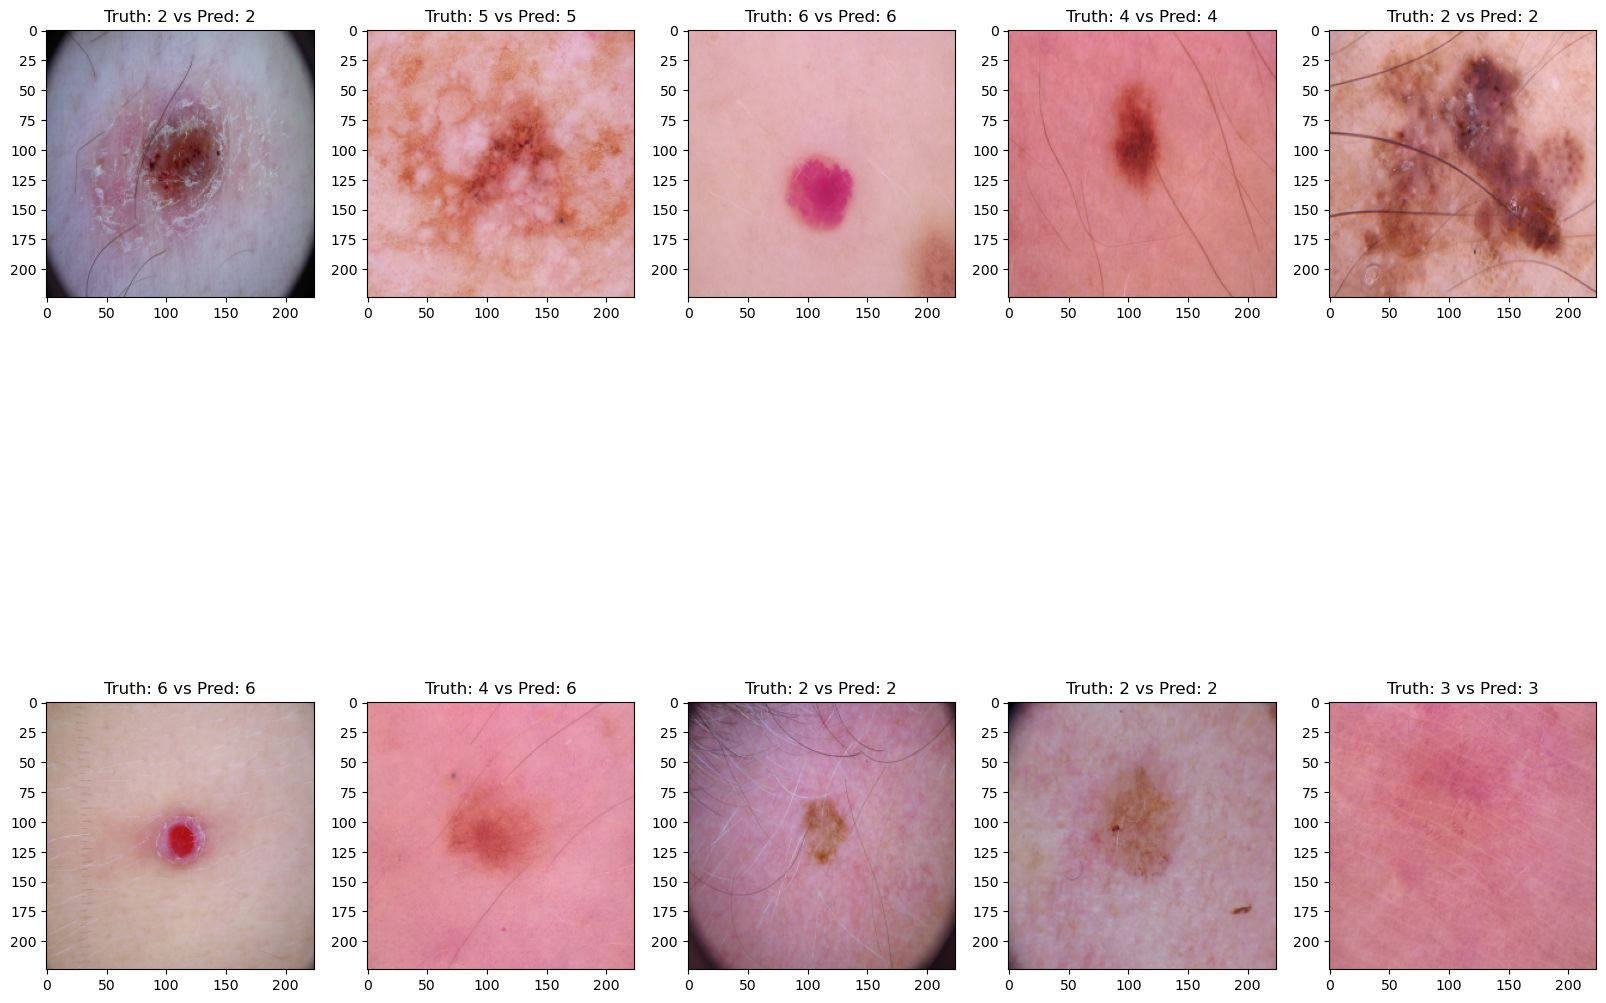

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(20,16))
for j in range(5):
    axes[0,j].imshow(images[j+10])
    axes[1,j].imshow(images[j+15], cmap="gray")
    axes[0,j].set_title(f"Truth: {labels[j+10]} vs Pred: {preds[j+10]}")
    axes[1,j].set_title(f"Truth: {labels[j+15]} vs Pred: {preds[j+15]}")
plt.show()

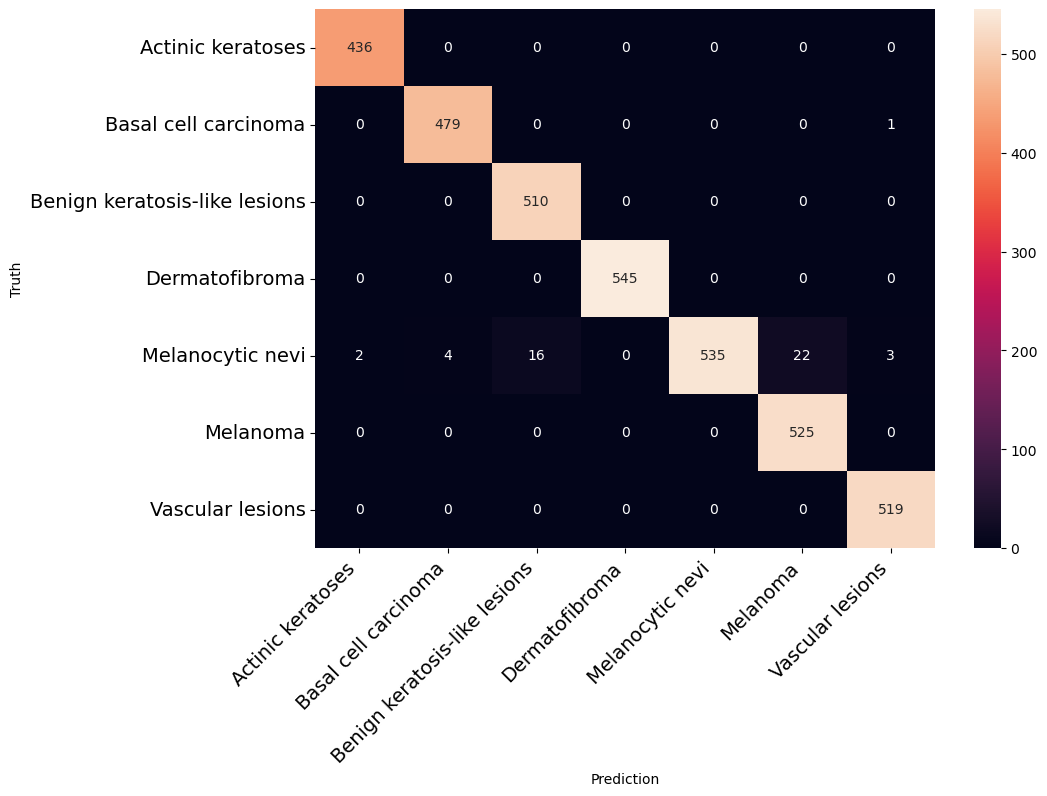

In [53]:
cm = confusion_matrix(labels,preds)
print_confusion_matrix(cm,class_names=['Actinic keratoses',
                                       'Basal cell carcinoma',
                                       'Benign keratosis-like lesions',
                                       'Dermatofibroma',
                                       'Melanocytic nevi',
                                       'Melanoma',
                                       'Vascular lesions'])

In [54]:
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       0.99      1.00      0.99       480
           2       0.97      1.00      0.98       510
           3       1.00      1.00      1.00       545
           4       1.00      0.92      0.96       582
           5       0.96      1.00      0.98       525
           6       0.99      1.00      1.00       519

    accuracy                           0.99      3597
   macro avg       0.99      0.99      0.99      3597
weighted avg       0.99      0.99      0.99      3597



In [44]:
model.save("test_skin.h5")